# Attention-based MIL demo.

In this exercise we are going to use self attention to aggregate features and tackle a classification problem using multiple instance learning.


## Creating a dataset

The ``ShapesDataset`` object produces images with a uniform random background colour, as well as a scattering of randomly-coloured shapes, placed at random positions.

For each of the possible shapes the data set can include in a given image, we can optionally specify a probability with which shapes of that kind will be included. In this demo we include spots, squares and octagons with probability 1, and stars with probability 0.5. We will consider star-containing images as positive images, and images without stars as negatives.

In [5]:
from torch_tools import ShapesDataset
from torch.utils.data import DataLoader

from torch import randn_like

from torchvision.transforms import Compose, ElasticTransform, RandomErasing
from torchvision.transforms import RandomRotation

img_size = 512
patch_size = 64
num_instances = (img_size * img_size) // (patch_size * patch_size)
batch_size = 16

print(f"Bag size = {(img_size // patch_size) ** 2}")

train_set = ShapesDataset(
    spot_prob=1.0,
    square_prob=1.0,
    octagon_prob=1.0,
    star_prob=0.5,
    input_tfms=Compose([lambda x: x + (randn_like(x) * 0.1), RandomRotation(180.0)]),
    target_tfms=Compose([lambda x: x[1]]),
    image_size=img_size,
    num_shapes=3,
    seed=1234,
)

valid_set = ShapesDataset(
    spot_prob=1.0,
    square_prob=1.0,
    octagon_prob=1.0,
    star_prob=0.5,
    target_tfms=Compose([lambda x: x[1]]),
    image_size=img_size,
    num_shapes=3,
    seed=666,
)


train_loader = DataLoader(
    train_set,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_set,
    shuffle=False,
    batch_size=batch_size,
    drop_last=True,
)

Bag size = 64


### Visualising some example images

Before we proceed and implement the attention-MIL model, let us first take a look at some example images. While these images will be tiled for the MIL training, it is worth looking at them in their entirety at first.

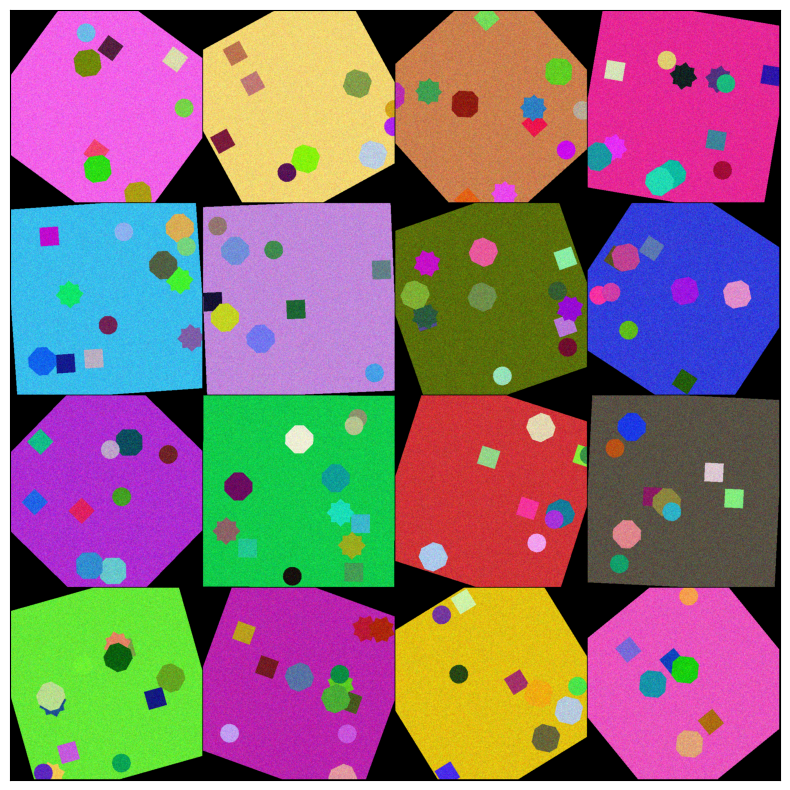

In [6]:
from torch import concat
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

images = []
for idx, (batch, _) in enumerate(train_loader):
    images.append(batch)
    break


grid = make_grid(concat(tuple(images), dim=0), nrow=int(batch_size ** 0.5)).permute(1, 2, 0)


figure, axis = plt.subplots(1, 1, figsize=(8, 8))

axis.imshow(grid.clip(0.0, 1.0))

axis.set_xticks([])
axis.set_yticks([])

figure.tight_layout()

Notice that all of the images contain spots, squares, and octogons, but only contain stars with probability 0.5. For this demo, the star-containing images are in the positive class.


### Visualising a tesselated image

When training the attention model, we are going to split each image in a mini-batch into patches, and then take advantage of the "attention" we pay to each patch. We can now visualise a "patched" image.

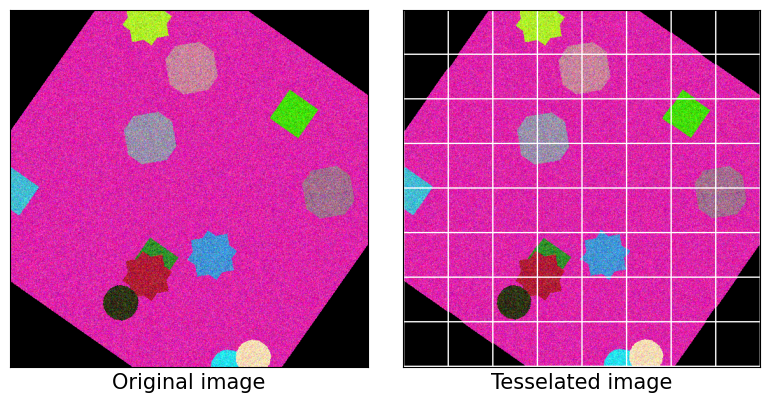

In [7]:
from torch_tools.torch_utils import patchify_img_batch

for batch, targets in train_loader:
    if targets[0].item() == 1.0:
        break

batch = batch[0].unsqueeze(0)

patches = make_grid(
    patchify_img_batch(batch, patch_size),
    nrow=img_size // patch_size,
    pad_value=1.0,
)

figure, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(
    batch.squeeze(0).permute(1, 2, 0).clip(0.0, 1.0),
    extent=(0, 1, 0, 1),
)
axes[1].imshow(
    patches.permute(1, 2, 0).clip(0.0, 1.0),
    extent=(0, 1, 0, 1),
)

axes[0].set_xlabel("Original image", fontsize=15)
axes[1].set_xlabel("Tesselated image", fontsize=15)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlim(left=0.0, right=1.0)
    axis.set_ylim(bottom=0.0, top=1.0)

figure.tight_layout()

## Creating the attention model

In [8]:

import torch
from torch import Tensor


from torch.nn import Module, Linear, Dropout
from torch.optim import Adam

from torch.cuda import is_available

from torch_tools import ConvNet2d, FCNet


DEVICE = "cuda" if is_available() else "cpu"


class SelfAttention(Module):
    """Self attention for aggregating MIL features.

    Parameters
    ----------
    input_dim : int
        Number of features.
    hidden_dim : int
        Hidden dimension size.
    output_dim : int
        Size of the output dimension.

    """
    def __init__(self, input_dim : int, hidden_dim : int, output_dim : int):
        super().__init__()
        self.query_linear = Linear(input_dim, hidden_dim)
        self.key_linear = Linear(input_dim, hidden_dim)
        self.value_linear = Linear(input_dim, output_dim)
        self.dropout = Dropout(0.1)


    def attention_weights(self, batch):
        batch_size, num_instances, embedding_dim = batch.shape

        Q = self.query_linear(batch) # (bs, num_instances, latent_size)
        K = self.key_linear(batch)   # (bs, num_instances, latent_size)

        attention_scores = torch.bmm(Q, K.transpose(-1, -2)) / (Q.size(-1) ** 0.5)  # (batch_size, sequence_length, sequence_length)

        attention_weights = attention_scores.softmax(dim=-1)  # (batch_size, sequence_length, sequence_length)

        return attention_weights

    def forward(self, batch : Tensor):
        """Pass ``batch`` through the model.

        Parameters
        ----------
        batch : Tensor
            A mini-batch of inputs: (bs, num_instances, latent_feats)

        Returns
        -------
        Tensor
            Features.

        """
        batch_size, num_instances, embedding_dim = batch.shape

        attention_weights = self.attention_weights(batch)
        V = self.value_linear(batch) # (bs, num_instances, output_dim)


        return torch.bmm(attention_weights, V)

class AttentionNet(Module):
    """Attention model."""

    def __init__(self):
        """Build attention model."""
        super().__init__()

        self.latent = 32
        self.attn_hidden = 32
        self.output_size = 16

        self.encoder = ConvNet2d(
            out_feats=self.latent,
            in_channels=3,
            encoder_style="resnet18",
            pretrained=True,
            pool_style="avg",
        )

        self.self_attn = SelfAttention(input_dim=self.latent, hidden_dim=self.attn_hidden, output_dim=self.output_size,)

        self.agg = Linear(in_features=self.output_size * num_instances, out_features=1)



    def forward(self, batch: Tensor) -> Tensor:
        """Pass ``batch`` through the model."""

        # Extract features: (N, feats)
        latent = self.encoder(patchify_img_batch(batch, patch_size))

        latent = latent.reshape(len(batch), num_instances, self.latent)

        attn_output = self.self_attn(latent)

        return self.agg(attn_output.reshape(len(batch), -1)).sigmoid()

model = AttentionNet()


In [9]:
model.to(DEVICE)

optimiser = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

## Training the model

In [10]:
from typing import Optional, Dict

from torch import set_grad_enabled, no_grad
from torch.nn.functional import binary_cross_entropy as bce
from torch import rand
from torch.nn.functional import normalize

from numpy import mean

@no_grad()
def accuracy(prediction : Tensor, target : Tensor):
    """Compute the accuracy.

    Parameters
    ----------
    prediction : Tensor
        The predictions.
    target : Tensor
        The target.

    Returns
    -------
    float
        The accuracy score.

    """
    return ((prediction >= 0.5).flatten().cpu() == target.cpu()).float().mean().item()


def one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Optional[Adam] = None,
):
    """Train or validate the model for a single epoch.

    Parameters
    ----------
    model : Module
        Classifier model.
    data_loader : DataLoader
        Image-yielding data loader.
    optimiser : Adam, optional
        The optimiser to fit the model with.

    """
    metrics = {"loss": [], "accuracy": []}

    if optimiser is not None:
        model.train()
    else:
        model.eval()

    for batch, targets in data_loader:
        if optimiser is not None:
            optimiser.zero_grad()

        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        with set_grad_enabled(optimiser is not None):
            pred = model(batch)

        loss = bce(pred, targets.reshape(-1, 1))



        metrics["loss"].append(loss.item())
        metrics["accuracy"].append(accuracy(pred, targets))

        if optimiser is not None:
            loss.backward()
            optimiser.step()

    return {key: mean(val) for key, val in metrics.items()}

In [11]:
from time import perf_counter

epochs = 5

train_metrics, valid_metrics = [], []

for epoch in range(epochs):
    start_time = perf_counter()

    train_metrics.append(one_epoch(model, train_loader, optimiser))
    valid_metrics.append(one_epoch(model, valid_loader))

    stop_time = perf_counter()

    print(f"Epoch {epoch + 1} time = {stop_time - start_time:.6f} seconds")

Epoch 1 time = 27.360746 seconds
Epoch 2 time = 26.019002 seconds
Epoch 3 time = 26.636892 seconds
Epoch 4 time = 26.570597 seconds
Epoch 5 time = 27.473001 seconds


## Evaluating the performance

   loss_train  accuracy_train  loss_valid  accuracy_valid  epoch
0    0.336344        0.848790    0.317605        0.889113      1
1    0.085112        0.971774    0.027499        0.990927      2
2    0.045582        0.985887    0.074362        0.975806      3
3    0.074175        0.977823    0.014532        0.994960      4
4    0.038043        0.987903    0.040856        0.989919      5


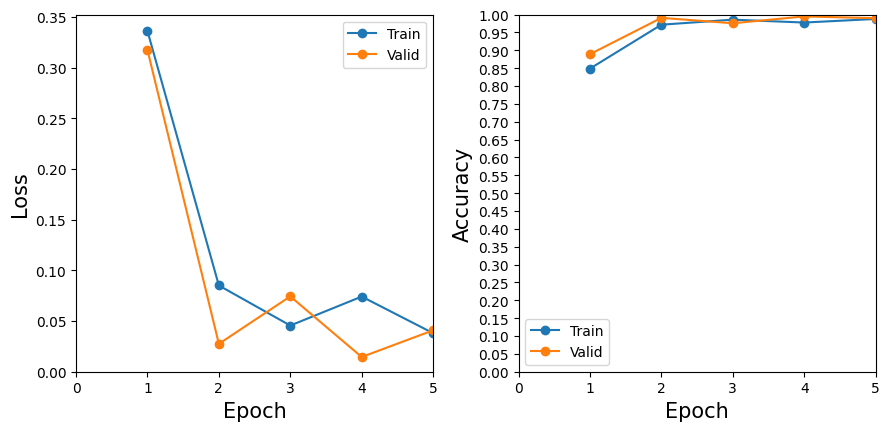

In [12]:
import matplotlib.pyplot as plt
from pandas import DataFrame

from numpy import arange, diff, linspace


metrics = DataFrame(train_metrics).join(
    DataFrame(valid_metrics),
    lsuffix="_train",
    rsuffix="_valid",
)
metrics["epoch"] = arange(1, len(metrics) + 1, 1)

print(metrics)

#
figure, axes = plt.subplots(1, 2, figsize=(9, 4.5))


for axis, metric in zip(axes.ravel(), ["loss", "accuracy"]):
    for split in ["train", "valid"]:
        axis.plot(
            metrics.epoch,
            metrics[f"{metric}_{split}"],
            "-o",
            label=split.capitalize(),
        )

    axis.set_ylabel(metric.capitalize(), fontsize=15)
    axis.set_ylim(bottom=0.0)


axes[1].set_yticks(linspace(0, 1, 21))
axes[1].set_ylim(bottom=0.0, top=1.0)

for axis in axes.ravel():

    axis.legend()
    axis.set_xlim(left=0, right=epochs)
    axis.set_aspect(diff(axis.get_xlim()) / diff(axis.get_ylim()))
    axis.set_xlabel("Epoch", fontsize=15)


figure.tight_layout()

## Visualising some results

/home/jim/CodeProjects/TorchTools/src/torch_tools/datasets/_shapes_dataset.py:92: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  "square": lambda x: square(2 * x),


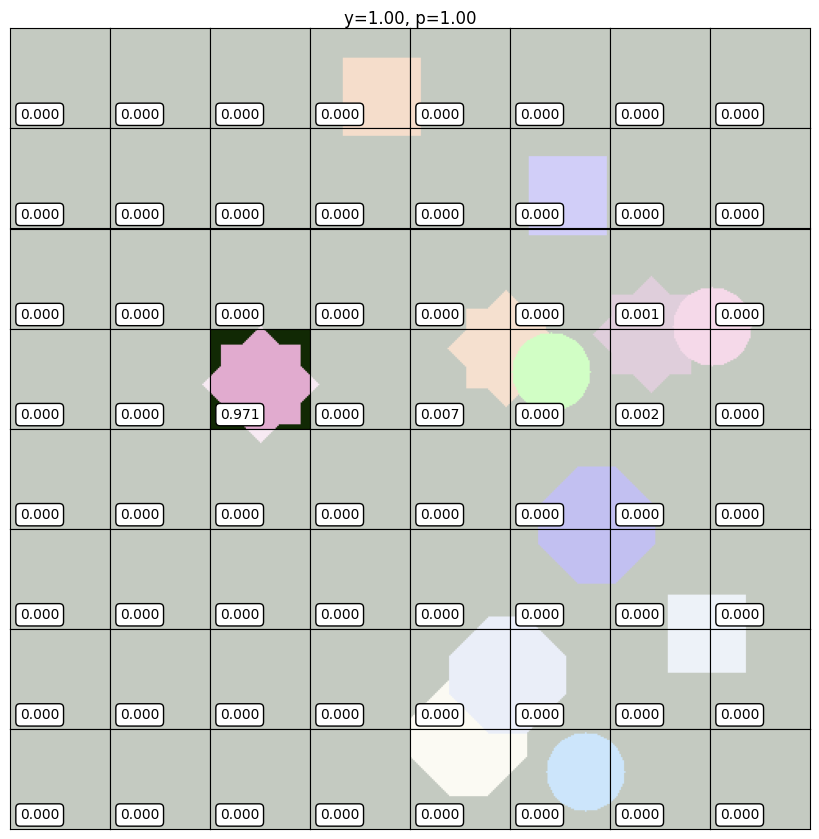

In [13]:
model.eval()

with no_grad():
    for batch, target in valid_loader:

        batch = batch[1].unsqueeze(0)
        target = target[1].unsqueeze(0)

        latent = model.encoder(patchify_img_batch(batch, patch_size).to(DEVICE))
        latent = latent.reshape(len(batch), num_instances, model.latent)

        attention = model.self_attn.attention_weights(latent).cpu()

        pred = model(batch.to(DEVICE)).cpu()

        break



attention = attention.squeeze().mean(dim=0)
attention /= attention.sum()

alphas = (attention / attention.max()).clip(0.25)

batch = patchify_img_batch(batch, patch_size)


patch_length = img_size // patch_size


figure, axes = plt.subplots(patch_length, patch_length, figsize=(8, 8.2))

for patch, axis, att, alpha in zip(batch, axes.ravel(), attention, alphas):
    patch = patch.permute(1, 2, 0).numpy()

    axis.imshow(patch, alpha=alpha.item())

    axis.text(
        0.1,
        0.1,
        f"{round(att.item(), 3):.3f}",
        transform=axis.transAxes,
        bbox={"boxstyle": "round", "facecolor": "white"},
    )
    axis.set_xticks([])
    axis.set_yticks([])

figure.suptitle(f"y={target.item():.2f}, p={pred.item():.2f}", y=1.0)
figure.tight_layout(pad=0, h_pad=0.0, w_pad=0)